# Introduction 

In [3]:
!pip install -U yellowbrick

# Load the libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

import numpy as np 
import pandas as pd

import scipy as sp 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

import operator 
import heapq 
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Load the data

In [7]:
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [35]:
print(train.shape)
train.info()

(10000038, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [36]:
print(test.shape)
test.info()

(5000019, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [37]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [38]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [39]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [40]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [41]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


# DATA Preprocessing

In [42]:
metadata =pd.merge(movies,imdb,how = 'left',on = 'movieId')
genome_score_tags = pd.merge(genome_scores,genome_tags, how='left',on='tagId')

In [21]:
print(f'The metadata dataset has {metadata.shape[0]} rows/entries and {len(metadata.columns)} coulumns')
percentange=metadata.isnull().mean().round(4) * 100
count = metadata.isnull().sum()
count_percentage = pd.DataFrame({'Count':count,'Percentage': percentange,},index=metadata.columns)
count_percentage

The metadata dataset has 62423 rows/entries and 8 coulumns


,Count,Percentage
movieId,0,0.00
title,0,0.00
genres,0,0.00
title_cast,47222,75.65
director,47076,75.41
runtime,48902,78.34
budget,55140,88.33
plot_keywords,48039,76.96


In [22]:
metadata1 = metadata.copy() 

metadata1.drop(['title_cast','director','budget','plot_keywords'],
  axis='columns',inplace=True)

metadata1['runtime'].fillna((metadata1['runtime'].mean()), inplace=True)

In [23]:
df = pd.merge(metadata1,genome_score_tags,how = 'left',on = 'movieId')

In [24]:
#extracting released year
df['release_year']=df['title'].str[-5:-1] 
df['release_year'].replace('[^\(.*\)?]','', regex=True)
#spliting the genres into a list
df['genres']=df['genres'].str.split('|')

In [25]:
train_min = train[:10000]
train_df =pd.merge(df,train_min,how = 'left',on = 'movieId')
test_min = test[:10000]
test_df = pd.merge(df,test_min,how = 'left',on = 'movieId')
print(f'The train_df dataset {test_df.shape[0]} rows/entries and {len(train_df.columns)} coulumns')
print(f'The test_df dataset {train_df.shape[0]} rows/entries and {len(test_df.columns)} coulumns')

The train_df dataset 23190655 rows/entries and 11 coulumns
The test_df dataset 22765400 rows/entries and 9 coulumns


In [26]:
train_df.drop('timestamp',axis=1,inplace=True)

In [27]:
train_features = train_df.drop(['rating'],axis=1)
train_features.shape

(22765400, 9)

In [28]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='char')
train_transformed = tf.fit_transform(train_features).toarray()

In [19]:
scaler = StandardScaler(with_mean=False)
pca =PCA()
pipeline = make_pipeline(scaler,pca)

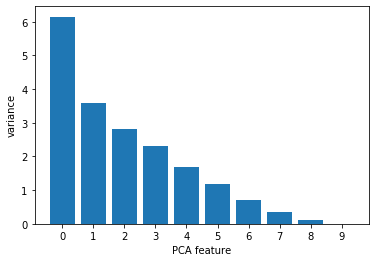

In [146]:
pipeline.fit_transform(train_transformed)
features=range(pca.n_components_)
features = features
plt.bar(features,pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [ ]:
scaler = StandardScaler(with_mean=False)
scaled= scaler.fit_transform(train_transformed)
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3)
y_kmeans = kmeans.fit_predict(scaled)

In [195]:
plt.scatter(scaled[y_kmeans == 0, 0],scaled[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1, 0], scaled[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2, 0], scaled[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

# Modelling

## Content-Based Filtering

In trying to achieve the ultimate user experience that keeps users coming back to use the product. The company needs to tailor the product to the user through a filtering process.A content-based recommender system strives to create the best user experience by tailoring the product to the user.This is done by using content based filtering methods,these methods utilise the desciption of the item and a profile of the user's preferences (basically the content).The method is efficient when there is known data on the item (such as the title,description,genre etc.) but it does not use the data on the user.With all that theory in mind, The Content-Based Filtering I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. The movies.csv dataset is used to build the recommender.

In [8]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [9]:
#create a sample of the movies genres  
sample_genre= movies['genres'].head(20000)
sample_genre.shape

(20000,)

### Vectorizing the content 

The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:

In [10]:
#create a vectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
genre_vec = tf.fit_transform(sample_genre)

### Finding the Similarities between movies

To find the similarities between two movies we made use of the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between the two movies.We made use of sklearn's linear_kernel to generate the cosine similarities. 

In [11]:
cosine_sim = linear_kernel(genre_vec, genre_vec)

In [12]:
def genre_recommendations(movie_title):

    "Function that generates movie recommendations based on the cosine similarity score of movie genres "
    "
 
    # Build a 1-dimensional array with movie titles
    movie_index=pd.Series(movies.index,index=movies['title'])
    
    #generate  similarities between the movie title and movie index based on genre
    similarities=list(enumerate(cosine_sim[movie_index[movie_title]]))
    #generate the top 10 similarities
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[1:11]
    recommended_movies= movies['title'].iloc[[i[0] for i in similarities]]
    
    return recommended_movies

### Top 10 recommendations based on a movie title 

In [13]:
genre_recommendations('Toy Story (1995)')

2203                                           Antz (1998)
3021                                    Toy Story 2 (1999)
3653        Adventures of Rocky and Bullwinkle, The (2000)
3912                      Emperor's New Groove, The (2000)
4780                                 Monsters, Inc. (2001)
9949     DuckTales: The Movie - Treasure of the Lost La...
10773                                     Wild, The (2006)
11604                               Shrek the Third (2007)
12969                       Tale of Despereaux, The (2008)
17431    Asterix and the Vikings (Astérix et les Viking...
Name: title, dtype: object

In [14]:
genre_recommendations('Waiting to Exhale (1995)')

10                  American President, The (1995)
51                         Mighty Aphrodite (1995)
57               Postman, The (Postino, Il) (1994)
92                          Beautiful Girls (1996)
193                 Something to Talk About (1995)
221                        Don Juan DeMarco (1995)
229    Eat Drink Man Woman (Yin shi nan nu) (1994)
278                           Nobody's Fool (1994)
346                        Corrina, Corrina (1994)
354                     I Like It Like That (1994)
Name: title, dtype: object

# Collaborative Filtering
Collaborative Filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

https://realpython.com/build-recommendation-engine-collaborative-filtering/

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

***Surprise:***

* Provides various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVDpp, NMF), and many others.
* Provides tools to evaluate, analyse and compare the algorithms’ performance.

https://surprise.readthedocs.io/en/stable/getting_started.html http://surpriselib.com/#:~:text=Surprise%20is%20a%20Python%20scikit,perfect%20control%20over%20their%20experiments.

From the Suprise library, the follwoing algorithms were used:

# Basic algorithms
***NormalPredictor:*** this algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.

***BaselineOnly:*** this algorithm predicts the baseline estimate for given user and item.

# k-NN algorithms
***KNNBasic:*** this is a basic collaborative filtering algorithm.

***KNNWithMeans:*** this is a basic collaborative filtering algorithm, taking into account the mean ratings of each user.

***KNNWithZScore:*** this is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

***KNNBaseline:*** is a basic collaborative filtering algorithm taking into account a baseline rating.

# Matrix Factorization-based algorithms
***SVD:*** this algorithm is equivalent to Probabilistic Matrix Factorization ( which makes use of data provided by users with similar preferences to offer recommendations to a particular user).

***SVDpp:*** this algorithm is an extension of SVD that takes into account implicit ratings.

***NMF:*** this is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

***SlopeOne:*** this is a straightforward implementation of the SlopeOne algorithm.

***Coclustering:*** is a collaborative filtering algorithm based on co-clustering.

https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

# Using the Suprise Library

In [ ]:
#Loading 10000 dataset
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']].head(10000), Reader)

In [ ]:
 #Implement an algorithm
algo = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), 
                  KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

#Read 10000 dataset
data2 = Dataset.load_from_df(train[['userId', 'movieId', 'rating']].head(10000), Reader())

#Implementing algorithm for RMSE
algo_rmse=[]
for a in algo:
    
    cross_valid=cross_validate(a, data2, measures=['RMSE'], cv = 3)
    output=pd.DataFrame.from_dict(cross_valid).mean(axis=0)
    output=output.append(pd.Series([str(a).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    algo_rmse.append(output)

algo_rmse
surprise_results = pd.DataFrame(algo_rmse).set_index('Algorithm').sort_values('test_rmse')
surprise_results

Based on the table above containing test_rmse, fit_time, test_time values for the algorithms, we notice that the SVDpp, SVD and BaselineOnly algorithms are top three best performing algorithms. So we use the best performing top three for prediction and to find the Root Mean Squared Error (RMSE) values.

# Predicting with SVDpp algorithm

In [ ]:
#Loading 100000 dataset
data4 = Dataset.load_from_df(train[['userId', 'movieId', 'rating']].head(100000), Reader()) 

In [ ]:
trainset, testset = train_test_split(data4, test_size=0.05)

In [ ]:
from surprise import accuracy
#SVDpp model
svdpp=SVDpp(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)

#Fitting the model
svdpp.fit(trainset)

# Making prediction on the validation dataset
test_pred= svdpp.test(testset)

#Evaluating model performance
rsme_collabo = accuracy.rmse(test_pred,
                             verbose=True)

In [ ]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in test.itertuples(index=False):
    output=svdpp.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']]
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

In [ ]:
#Creating the "results" dataframe and convert to csv
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("SVDpp.csv", index=False)

# Predicting with BaselineOnly algorithm

In [ ]:
#Loading 1100000 dataset
data5 = Dataset.load_from_df(train[['userId', 'movieId', 'rating']].head(1100000), Reader()) 

In [ ]:
trainset, testset = train_test_split(data5, test_size=0.05)

In [ ]:
from surprise import accuracy
#BaselineOnly model
bsl_options = {'method': 'sgd','n_epochs': 40}
blo=BaselineOnly(bsl_options=bsl_options)

#Fitting the model
blo.fit(trainset)

# Making prediction on the validation dataset
test_pred= blo.test(testset)

#Evaluating model performance
rsme_collabo = accuracy.rmse(test_pred,
                             verbose=True)

In [ ]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in test.itertuples(index=False):
    output=blo.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']]
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

In [ ]:
#Creating the "results" dataframe and convert to csv
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("blo.csv", index=False)

# Predicting with SVD

In [ ]:
#Loading 1000000 dataset
data3 = Dataset.load_from_df(train[['userId', 'movieId', 'rating']].head(1000000), Reader()) 

In [ ]:
trainset, testset = train_test_split(data3, test_size=0.05)

In [ ]:
from surprise import accuracy
#SVD model
svd=SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)

#Fitting the model
svd.fit(trainset)

# Making prediction on the validation dataset
test_pred= svd.test(testset)

#Evaluating model performance
rsme_collabo = accuracy.rmse(test_pred,
                             verbose=True)

In [ ]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in test.itertuples(index=False):
    output=svd.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']]
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

In [ ]:
#Creating the "results" dataframe and convert to csv
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("SVD.csv", index=False)

# Hyperparameter Tuning

Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. Setting the correct combination of hyperparameters is the only way to extract the maximum performance out of models.

We decided to hypertune the SVD algorithm model, which was the best performing amongst the top three algorithm (since it had the lowest RMSE value).

https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020

In [ ]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data3)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

# Conclusion